# Análise de dados do datasus e Wikipedia
https://datasus.saude.gov.br/informacoes-de-saude-tabnet/  

---

Procedimentos hospitalares do SUS - por local de internação - Brasil  
Valor total por Unidade da Federação e Ano/mês processamento  
Período: Jan/2008 a Ago/2020  
<br>
<br>
https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o

---

Esta é uma lista da população das unidades federativas brasileiras segundo estimativas de 1º de julho de 2020 do Instituto Brasileiro de Geografia e Estatística (IBGE).  

# Leitura e processamento inicial dos dados

In [ ]:
# imports...
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FixedLocator
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date

# personalizando opções gerais dos módulos
pd.options.display.float_format = lambda item: f'{item:.2f}'
sns.set_style("whitegrid")

Lendo dados do datasus

In [ ]:
# url do dataset
datasus_url = 'https://raw.githubusercontent.com/LucasGabrielB/-Alura-Bootcamp-Data-Science-Aplicada/main/Modulo-01/datasets/Valor%20total%20por%20Ano-m%C3%AAs%20processamento%20segundo%20Unidade%20da%20Federa%C3%A7%C3%A3o.csv'

# criando o dataframe apartir da url do arquivo
df_datasus = pd.read_csv(datasus_url,
                 encoding='ISO-8859-1',
                 sep=';',
                 skiprows=3,
                 skipfooter=12,
                 thousands='.',
                 decimal=',',
                 engine='python',
                 na_values='-',
                 index_col='Unidade da Federação')

# removendo o codigo da UF
df_datasus.index = [' '.join(i[1:]) for i in df_datasus.index.str.split(' ')]

In [ ]:
df_datasus.head()

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,2010/Nov,2010/Dez,2011/Jan,2011/Fev,2011/Mar,2011/Abr,...,2017/Jun,2017/Jul,2017/Ago,2017/Set,2017/Out,2017/Nov,2017/Dez,2018/Jan,2018/Fev,2018/Mar,2018/Abr,2018/Mai,2018/Jun,2018/Jul,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,2019/Mai,2019/Jun,2019/Jul,2019/Ago,2019/Set,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,Total
Rondônia,1388528.39,2931283.42,1541682.52,1525314.96,1645953.84,1406150.68,3065279.01,3231494.61,3117178.63,3068430.44,2825838.52,2931173.58,2885269.07,2860103.74,3684944.68,3607289.68,3774356.60,3706711.84,3763187.55,3533625.83,3605007.43,3907032.72,3939820.71,3901084.11,3684407.02,3623015.58,3890461.90,4193533.87,4534400.67,4451208.03,4874592.78,4460802.38,5067886.24,4511092.85,4394680.50,4098741.80,4411499.48,3868617.95,4298702.78,5062171.26,...,7948291.63,8438077.45,7656644.83,8047742.98,8657206.23,8150893.68,7507845.13,7998345.94,8893683.69,8867793.32,8871408.50,8501601.67,8315107.81,8525499.78,9177611.46,7368996.38,8835095.43,8328186.64,8408512.77,9351705.82,8143007.97,8949741.77,9630553.15,9581970.31,7891114.05,9792370.67,9170787.53,8816846.71,10024554.15,9675423.70,8085025.66,9221412.18,7493310.88,8092260.11,7273843.63,7652120.28,8725530.68,11152107.08,10285455.78,929129659.72
Acre,902416.00,1497206.26,1794028.48,1730469.42,1819443.92,1828496.00,2511754.59,2089107.14,2275708.53,1923886.57,1756986.80,2235639.98,2497116.43,2253558.01,2122673.92,2834317.62,2722065.97,2432831.95,2630190.65,2307579.00,nan,2826477.02,2170791.18,2541526.44,2491042.33,1954473.90,2389996.38,2654878.60,2844085.21,2336207.19,2125143.06,2430293.67,2377738.44,2184746.84,2468452.90,2516284.54,3051370.08,2629104.42,2485451.79,2685361.47,...,2397512.85,2348760.00,3139155.41,2765062.92,4540084.78,4120228.96,2610454.55,3576595.19,2444567.37,2602434.35,3064163.42,2276236.69,3239474.10,3126429.88,2998865.51,2619709.86,3018048.94,3342614.24,2123426.26,2664654.52,1906429.95,3096439.63,2411628.00,2840630.58,3260153.59,3250722.84,3204998.88,3052745.65,3124802.29,3021521.75,2874871.28,3331803.55,3417691.07,3076003.20,2286642.60,2896340.24,3045245.80,3915193.20,nan,420668039.63
Amazonas,4735529.42,7118990.57,8196635.49,8259378.42,7831399.90,8477273.62,9368858.72,9352532.70,9363099.35,8618318.83,6555549.08,7777645.88,7403068.36,6683346.89,9927781.20,8844511.21,9079035.96,8832894.53,9373395.97,9578326.03,9730634.16,9179252.65,8314648.93,9050439.39,9419460.86,8680178.57,9168055.41,9897901.80,9651362.37,10854599.47,10417122.89,8718347.13,8221592.12,9613977.03,9927574.41,9470661.21,9736750.91,8745259.80,9380112.36,10179342.29,...,12789637.85,14376990.41,14240071.26,13594647.25,14584288.95,13158724.61,13169660.32,13572263.03,13083081.70,14322305.22,14643340.51,14632208.09,14500521.14,14840533.42,14427620.91,15818964.25,16358462.57,15391163.74,14154362.85,16791397.31,14369987.43,16339024.96,15622910.63,16483166.92,15422243.28,15961988.04,15787896.78,16515441.67,15731201.23,15744605.61,14346553.60,16018459.07,14913745.37,15068304.35,13509579.29,19658585.46,20897542.93,19346450.18,14726443.67,1771654871.23
Roraima,657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,910424.17,1191770.32,1056218.71,1244339.25,1085679.25,969528.54,1393226.70,1273734.17,1552638.50,1490587.74,1596751.80,1848998.68,1701611.25,1164711.18,1434809.17,1603817.28,1437340.80,1332094.01,1900513.75,1933875.49,1773958.29,1804729.73,1846639.32,1643518.23,1843163.29,1807885.17,1674871.65,1250999.28,1257275.43,1171045.72,1389668.67,1344865.94,...,2755620.24,2878177.60,2921978.36,2794080.79,2512259.50,2508514.18,2635287.45,2914195.21,2881281.13,2740423.51,2695484.62,261

Lendo dados da Wikipedia

In [ ]:
# url da pagina
wikipedia_url = 'https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o'

# extraindo o dataframe apartir da url da pagina
df_wikipedia = pd.read_html(wikipedia_url)[0]
df_wikipedia = df_wikipedia[['Unidade federativa', 'População']]
df_wikipedia.set_index('Unidade federativa', inplace=True)

# convertendo os valores
df_wikipedia['População'] = df_wikipedia['População'].str.replace(' ', '').astype(int)

In [ ]:
df_wikipedia.head()

,População
Unidade federativa,
São Paulo,46289333
Minas Gerais,21331292
Rio de Janeiro,17366189
Bahia,14930634
Paraná,11516840


# Análise de dados 


In [ ]:
# dataframe com os gastos mensais
df_datasus_monthly = df_datasus.drop('Total', axis=1).T

def str_to_date(date_str: str) -> date:
    ''' converte uma string no formato "yyyy/[nome_mes_abreviado]" para uma data '''

    conversion_dict = {
        'Jan': 1,
        'Fev': 2,
        'Mar': 3,
        'Abr': 4,
        'Mai': 5,
        'Jun': 6,
        'Jul': 7,
        'Ago': 8,
        'Set': 9,
        'Out': 10,
        'Nov': 11,
        'Dez': 12,
    }
    
    year, month = date_str.split('/')
    month = conversion_dict[month]

    return date(int(year), month, 1)


# converte o indice para datas
df_datasus_monthly.index = df_datasus_monthly.index.map(str_to_date)

In [ ]:
df_datasus_monthly.head()

,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia,Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
2008-01-01,1388528.39,902416.00,4735529.42,657889.53,18864744.11,1120973.34,3441592.69,10723506.39,7985142.43,15539821.90,5947814.08,10723002.45,14393949.89,6243726.32,2780750.11,21211522.47,45671659.76,5456723.98,23025258.52,91678473.48,38266347.46,16504913.45,30931325.46,5377392.11,4795299.01,15310637.29,4745919.19
2008-02-01,2931283.42,1497206.26,7118990.57,777939.31,19553758.20,1268740.33,4985688.85,13559679.41,10079928.25,25735101.55,9509755.83,11386274.47,24181400.95,8376622.16,3676483.16,28189304.95,70194037.10,9102212.86,28394310.93,148677526.82,55384670.52,25651429.11,57363420.01,7002472.61,8684882.23,22258668.68,7632480.67
2008-03-01,1541682.52,1794028.48,8196635.49,718688.03,21937342.70,974651.24,6205612.60,13985142.36,10298372.45,28724625.75,10352238.59,12053643.87,29991302.71,8408336.22,5051473.61,34181483.52,79231336.95,10249595.97,44567062.94,156087269.23,53801318.85,26743524.89,51547794.07,8423933.19,7886243.14,21442515.75,9647203.26
2008-04-01,1525314.96,1730469.42,8259378.42,839994.39,20842829.69,1141137.32,4984482.09,14809416.46,10775976.33,30676457.06,10855108.50,12653528.76,34806197.97,9090794.82,5046063.36,39026934.13,77136537.58,11253833.56,44054604.82,161227125.43,52460306.69,27181488.26,56673338.49,8797487.68,8794109.79,20921212.45,11098732.99
2008-05-01,1645953.84,1819443.92,7831399.90,862347.96,23249952.88,866346.18,5511002.46,14505727.38,10398360.88,30604453.47,11160168.19,12215107.11,32147987.35,9338771.45,4741151.56,42949566.82,80554440.63,10198619.17,44911021.15,187119397.64,54419620.71,26845308.18,48397733.07,9770421.80,9231645.40,21615970.67,12891719.72


In [ ]:
df_datasus_monthly_melt = df_datasus_monthly.reset_index().melt(id_vars=['index']).set_index('index')
df_datasus_monthly_melt.columns = ['UF', 'Gasto']
df_datasus_monthly_melt.index.rename('Data', inplace=True)
df_datasus_monthly_melt.dropna(inplace=True)
df_datasus_monthly_melt.sort_values(by=['Gasto'], inplace=True, ascending=False)

In [ ]:
df_datasus_monthly_melt.head()

,UF,Gasto
Data,,
2020-07-01,São Paulo,366721243.71
2020-08-01,São Paulo,346512263.17
2019-08-01,São Paulo,313868712.55
2019-10-01,São Paulo,310847061.00
2020-06-01,São Paulo,306425499.30


In [ ]:
# criando colunas novas para gerar novas vizualizacoes
df_datasus_monthly_melt['Ano'] = df_datasus_monthly_melt.index.map(lambda item: item.year)
df_datasus_monthly_melt['Mes'] = df_datasus_monthly_melt.index.map(lambda item: item.month)

In [ ]:
df_datasus_monthly_melt.head()

,UF,Gasto,Ano,Mes
Data,,,,
2020-07-01,São Paulo,366721243.71,2020,7
2020-08-01,São Paulo,346512263.17,2020,8
2019-08-01,São Paulo,313868712.55,2019,8
2019-10-01,São Paulo,310847061.00,2019,10
2020-06-01,São Paulo,306425499.30,2020,6


In [ ]:
# adicionando coluna do gasto medio por dia de cada mes
month_days = {
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31,
}

df_datasus_monthly_melt['Gasto medio por dia'] = df_datasus_monthly_melt['Gasto'] / df_datasus_monthly_melt['Mes'].map(month_days)

In [ ]:
df_datasus_monthly_melt.head()

,UF,Gasto,Ano,Mes,Gasto medio por dia
Data,,,,,
2020-07-01,São Paulo,366721243.71,2020,7,11829717.54
2020-08-01,São Paulo,346512263.17,2020,8,11177814.94
2019-08-01,São Paulo,313868712.55,2019,8,10124797.18
2019-10-01,São Paulo,310847061.00,2019,10,10027324.55
2020-06-01,São Paulo,306425499.30,2020,6,10214183.31


In [ ]:
months_names = [
    'Janeiro',
    'Fevereiro',
    'Março',
    'Abril',
    'Maio',
    'Junho',
    'Julho',
    'Agosto',
    'Setembro',
    'Outubro',
    'Novembro',
    'Dezembro',
]

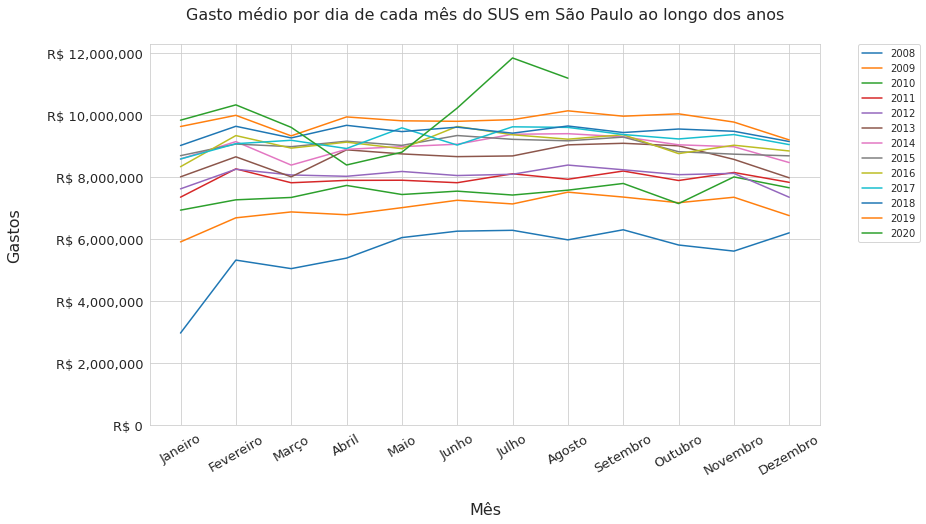

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_datasus_monthly_melt.query('UF == "São Paulo"'),
                  x='Mes',
                  y='Gasto medio por dia',
                  hue='Ano',
                  palette='tab10')

# personalizando os graficos
ax.yaxis.set_major_formatter(StrMethodFormatter('R$ {x:,.0f}'))
plt.title('Gasto médio por dia de cada mês do SUS em São Paulo ao longo dos anos', pad=25, fontsize=16)
plt.ylabel('Gastos', labelpad=25, fontsize=16)
plt.xlabel('Mês', labelpad=25, fontsize=16)
plt.xticks(rotation=30)
plt.ylim(bottom=0)
ax.xaxis.set_major_locator(FixedLocator(np.arange(1, 13)))
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.74), ncol=1)
ax.set_xticklabels(months_names)

plt.show()

Comparando dois estados de climas diferentes:

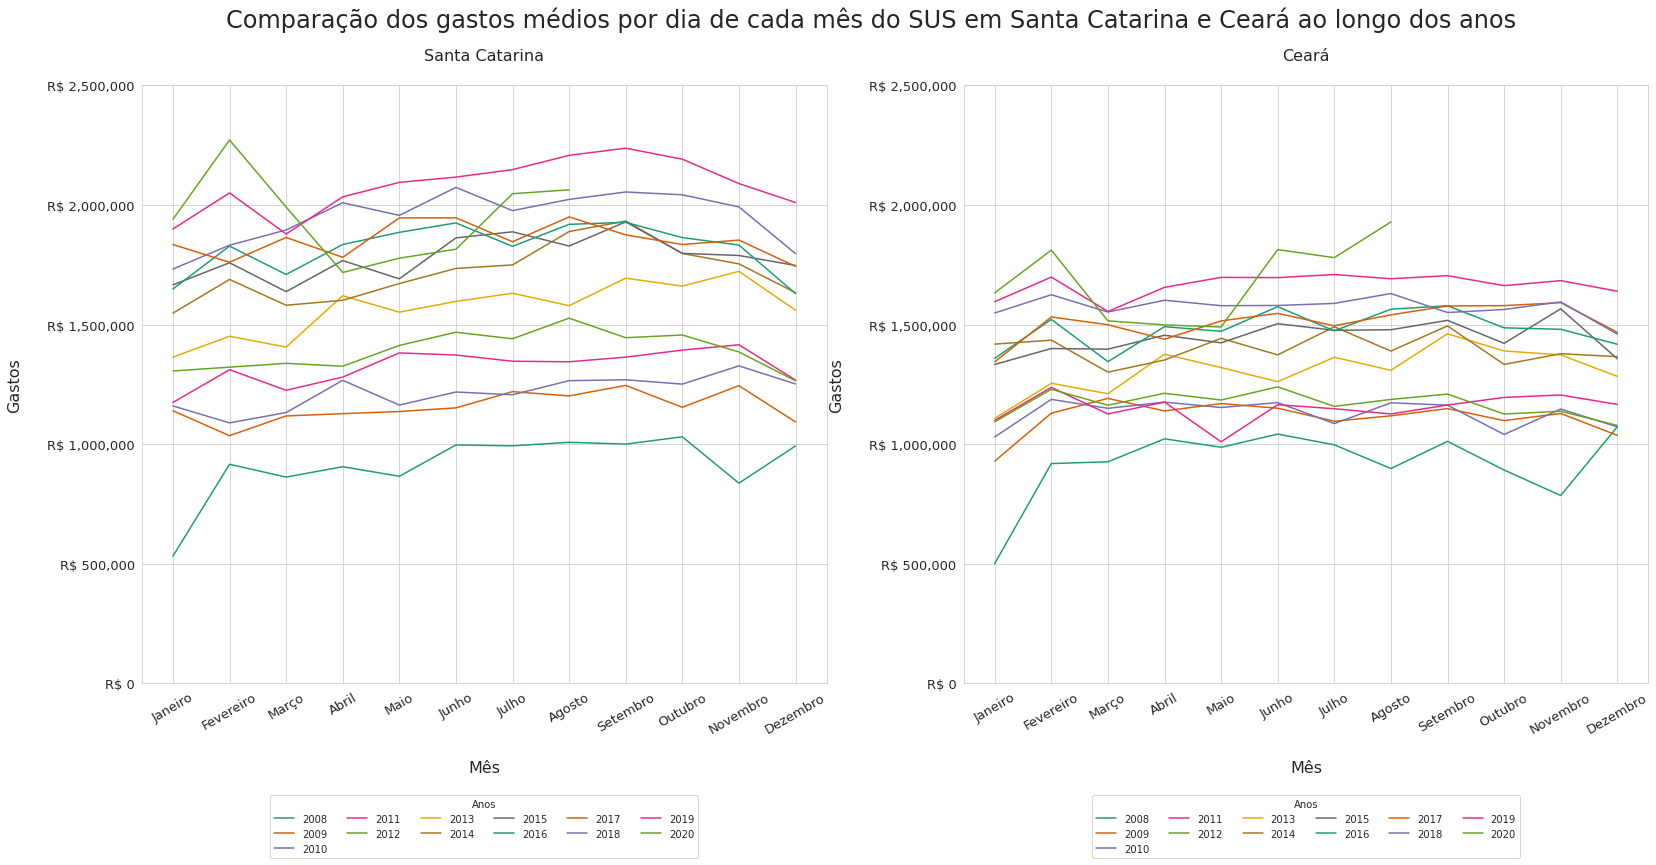

In [ ]:
plt.figure(figsize=(27, 11))

plt.subplot(121)
ax1 = sns.lineplot(data=df_datasus_monthly_melt.query('UF == "Santa Catarina"'),
                  x='Mes',
                  y='Gasto medio por dia',
                  hue='Ano',
                  palette='Dark2')

# personalizando o grafico 1
ax1.yaxis.set_major_formatter(StrMethodFormatter('R$ {x:,.0f}'))
ax1.xaxis.set_major_locator(FixedLocator(np.arange(1, 13)))
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.74), ncol=1)
ax1.set_xticklabels(months_names)
plt.title('Santa Catarina', pad=25, fontsize=16)
plt.ylabel('Gastos', labelpad=25, fontsize=16)
plt.xlabel('Mês', labelpad=25, fontsize=16)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(0.5,-0.3), loc='lower center',frameon=True, ncol=6, fancybox=True, title='Anos')
plt.ylim(0, 2.5e6)

plt.subplot(122)
ax2 = sns.lineplot(data=df_datasus_monthly_melt.query('UF == "Ceará"'),
                  x='Mes',
                  y='Gasto medio por dia',
                  hue='Ano',
                  palette='Dark2')

# personalizando o grafico 2
ax2.yaxis.set_major_formatter(StrMethodFormatter('R$ {x:,.0f}'))
ax2.xaxis.set_major_locator(FixedLocator(np.arange(1, 13)))
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
plt.legend(bbox_to_anchor=(0.5,-0.3), loc='lower center', frameon=True, ncol=6, fancybox=True, title='Anos')
ax2.set_xticklabels(months_names)
plt.title('Ceará', pad=25, fontsize=16)
plt.ylabel('Gastos', labelpad=25, fontsize=16)
plt.xlabel('Mês', labelpad=25, fontsize=16)
plt.xticks(rotation=30)
plt.ylim(0, 2.5e6)

plt.suptitle('Comparação dos gastos médios por dia de cada mês do SUS em Santa Catarina e Ceará ao longo dos anos', fontsize=24)

plt.show()